# Task2
Semantic Segmenation  
Pascal VOC  

Resblock 付き Encoder-Decoder CNN (以下、Resblockと呼ぶ) を含めた Task2 の実験結果をまとめました。  
Resblock の数は6つで、損失関数として L1, L2, GANLoss を用いて学習を行いました。  
このノートブックでは以下の2つの内容についてまとめました。

1. ベースラインと Piggyback、Resblock(GANLoss)の比較
2. 各 Resblock の比較 (L1, L2, GANLoss)

Resblockの結果があまり良くならなかったので、現在、追加で以下の実験を行っています。

- Resblock の数を 6 -> 9 でGANLoss
- Auto-Encoder の出力層のみ取り替える (パラメータ共有の条件を緩和)

In [1]:
# import
import os, sys

#from tqdm import tqdm
import datetime
import numpy as np
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from dataset import augmentations as aug
from dataset.pascal import VOCSegmentation, VOCSegmentation2
import networks as net
import modnets
from iouEval import iouEval, getColorEntry

In [2]:
# proxy
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
# gpu
os.environ['CUDA_VISIBLE_DEVICES'] = '1'  # 4GPUの場合 '0, 1, 2, 3'

In [3]:
palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128, 100, 100, 100]

def colorize_mask(mask):
    # mask: numpy array of the mask
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)

    return new_mask

def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

## dataset

In [4]:
num_classes = 22
path = '/export/data/pascal/VOC2012'
crop_size = 320
data_aug= aug.Compose([aug.CenterCrop(crop_size)])
loader = torch.utils.data.DataLoader(
    VOCSegmentation(path, train=False, augmentations=data_aug, transform=True,),
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=False,
)

In [5]:
num_classes = 22
path = '/export/data/pascal/VOC2012'
transform_list = transforms.Compose([
        transforms.Scale(400),
        transforms.CenterCrop(320),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

loader_norm = torch.utils.data.DataLoader(
    VOCSegmentation2(
                     path,
                     train=False,
                     shimodasan=False,
                     transform=transform_list,
                    ),
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=False)

/usr/local/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


## 1. ベースラインと Piggyback、Resblock(GANLoss)の比較

## model

### Scratch

In [6]:
Scratch = modnets.unet(False, 3, num_classes, '1s', 1e-2, 'binarizer')
model_path = 'best_models/scratch/unet_pascal/scratch_unet_pascal_best.pth'
checkpoint = torch.load(model_path)
state = OrderedDict()
for k, v in checkpoint['model_state'].items():
    name = k[7:]
    state[name] = v
Scratch.load_state_dict(state)
Scratch = Scratch.cuda()
Scratch = Scratch.eval()

### Full finetune

In [7]:
Full = modnets.unet(False, 3, num_classes, '1s', 1e-2, 'binarizer')
model_path = 'best_models/full_finetune/unet_pascal/decoder_finetune_unet_pascal_best.pth'
checkpoint = torch.load(model_path)
state = OrderedDict()
for k, v in checkpoint['model_state'].items():
    name = k[7:]
    state[name] = v
Full.load_state_dict(state)
Full = Full.cuda()
Full = Full.eval()

### Decoder finetune

In [8]:
Decoder = modnets.unet(False, 3, num_classes, '1s', 1e-2, 'binarizer')
model_path = 'best_models/decoder_finetune/unet_pascal/decoder_finetune_unet_pascal_best.pth'
checkpoint = torch.load(model_path)
state = OrderedDict()
for k, v in checkpoint['model_state'].items():
    name = k[7:]
    state[name] = v
Decoder.load_state_dict(state)
Decoder = Decoder.cuda()
Decoder = Decoder.eval()

### Piggyback

In [9]:
Piggyback = net.UNetDiffInit(mask_init='1s', mask_scale=1e-2, threshold_fn='binarizer', original=False)
Piggyback.add_dataset('pascal', 22)
Piggyback.set_dataset('pascal')
model_path = 'best_models/piggyback/unet_pascal/unet_binarizer_maskscale1e-2-none_lr1e-3-1e-3_decay500-500_1_700v2.pt'
checkpoint = torch.load(model_path)
Piggyback.load_state_dict(checkpoint['model_state'])
Piggyback = Piggyback.cuda()
Piggyback = Piggyback.eval()

Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Calling binarizer with threshold: 0.005
Creating model: Mask layers created.


### Resblock
loss : GANLoss

In [10]:
Resblock = modnets.resnet_generator(False)
model_path = 'best_models/resblock/auto_encoder_pascal_adv/best_resblock_auto_encoder_pascal_adv.pth'
checkpoint = torch.load(model_path)
state = OrderedDict()
for k, v in checkpoint['model_state'].items():
    name = k[7:]
    state[name] = v
Resblock.load_state_dict(state)
Resblock = Resblock.cuda()
Resblock = Resblock.eval()

## 出力結果

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


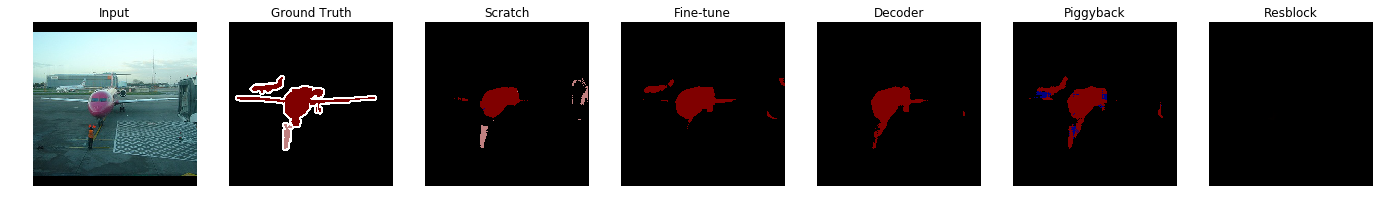

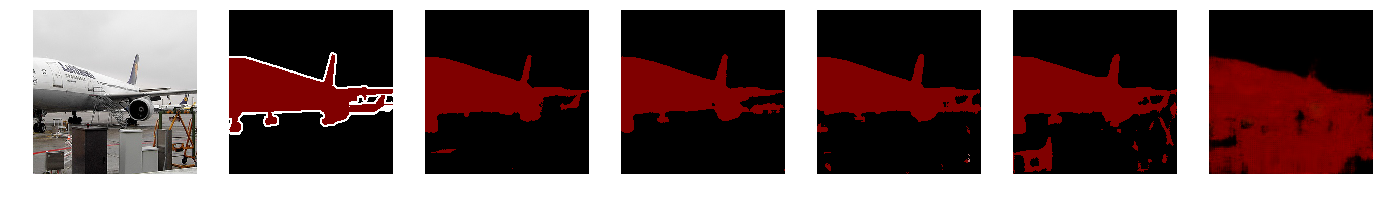

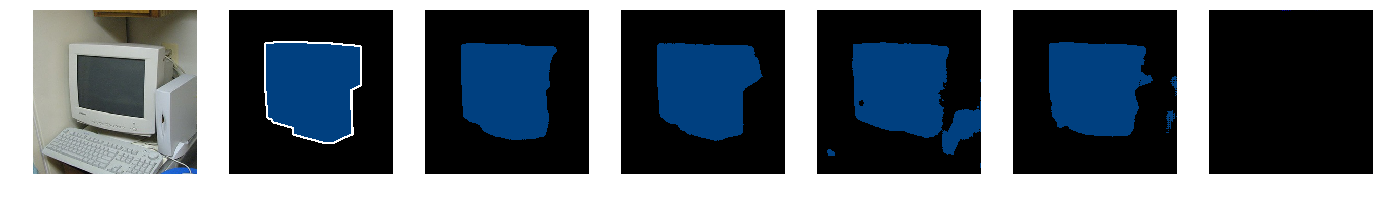

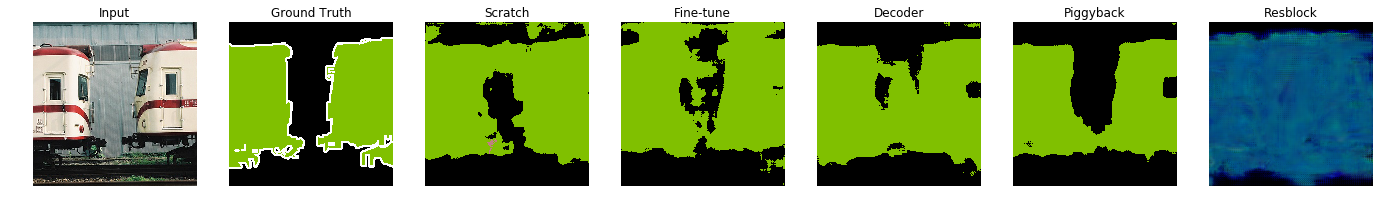

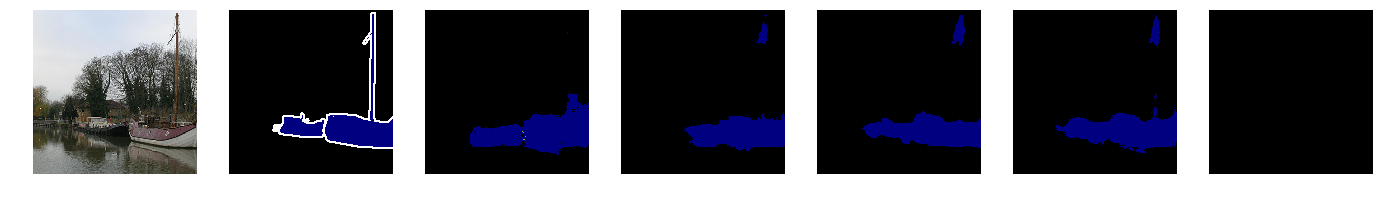

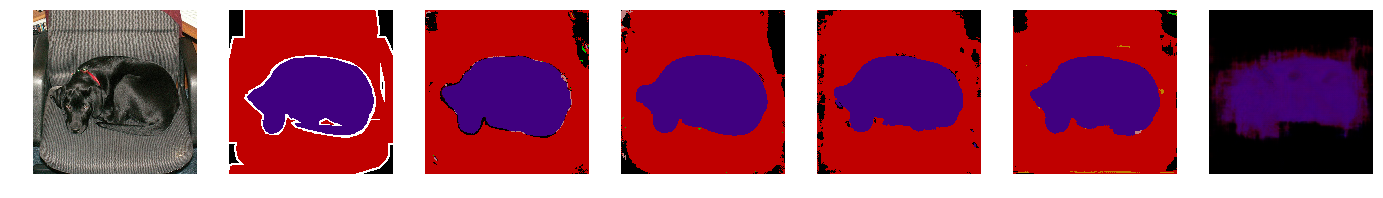

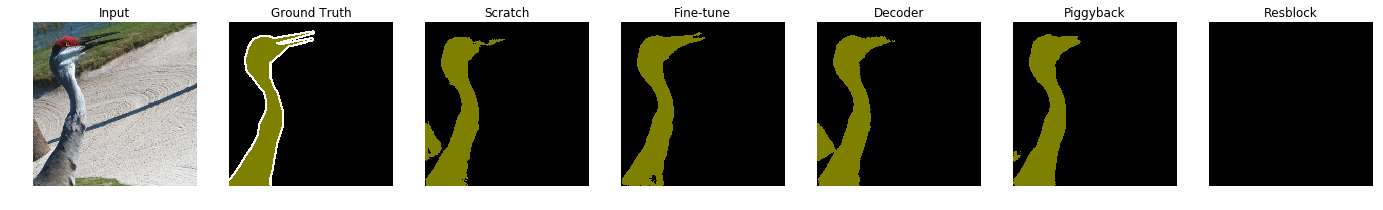

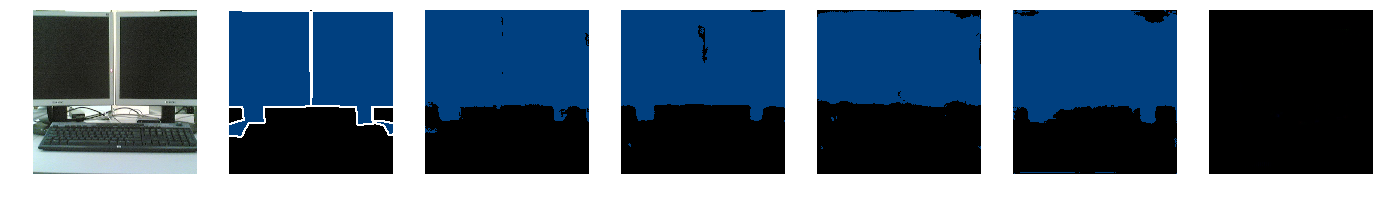

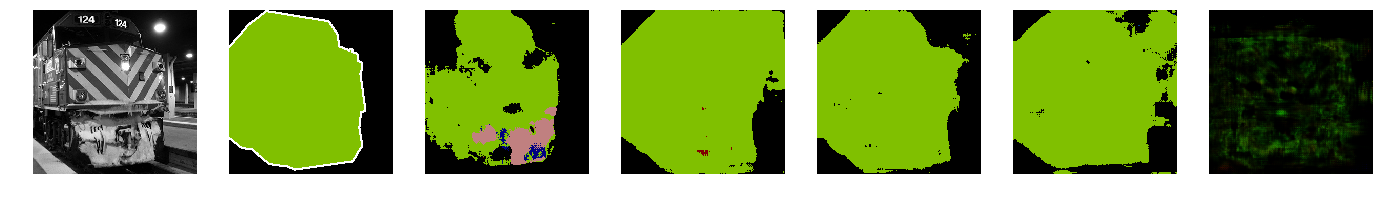

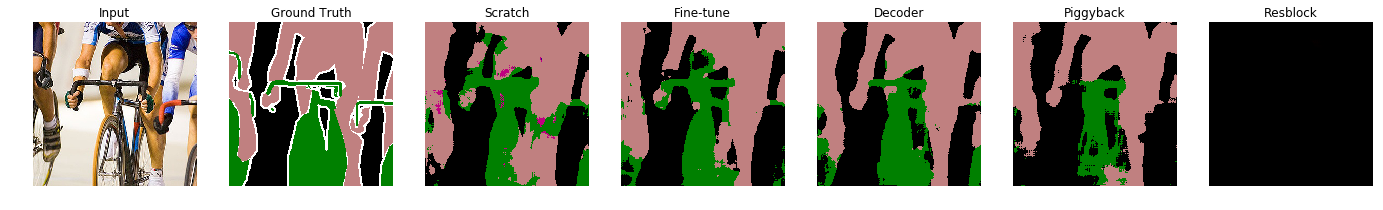

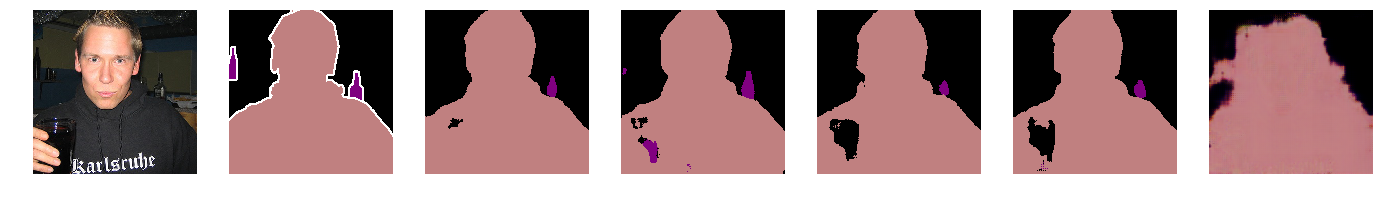

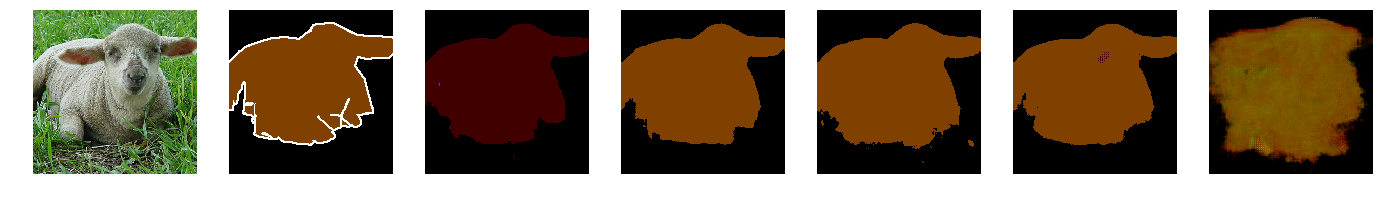

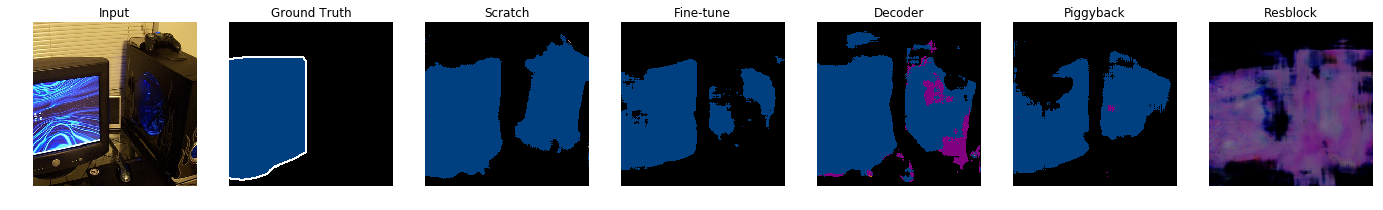

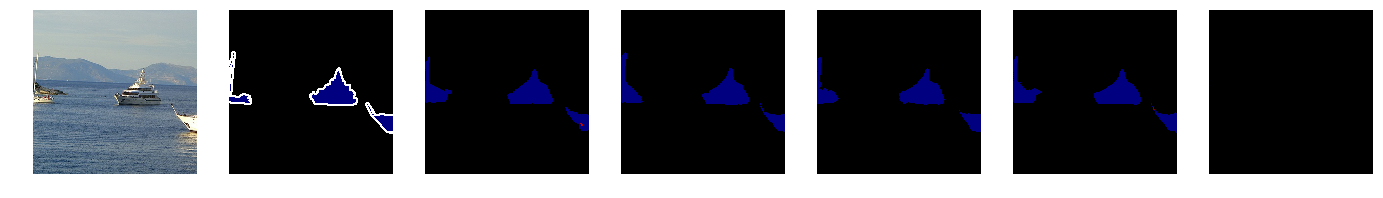

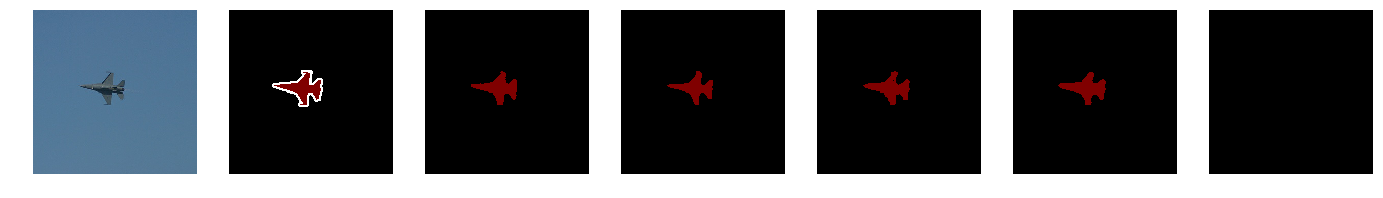

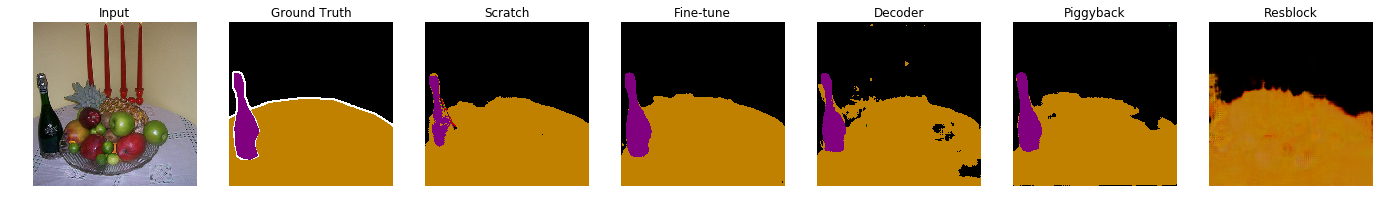

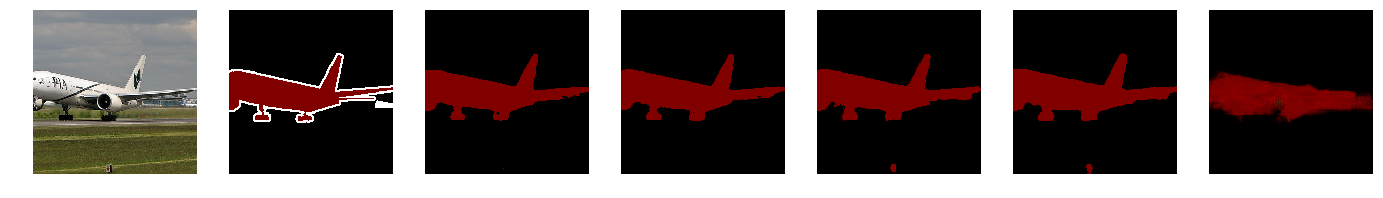

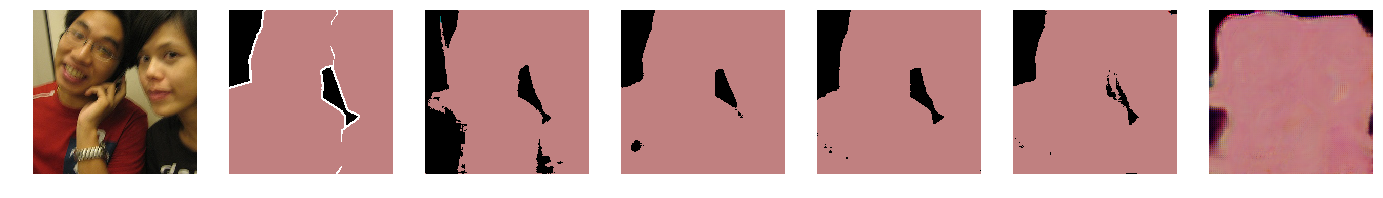

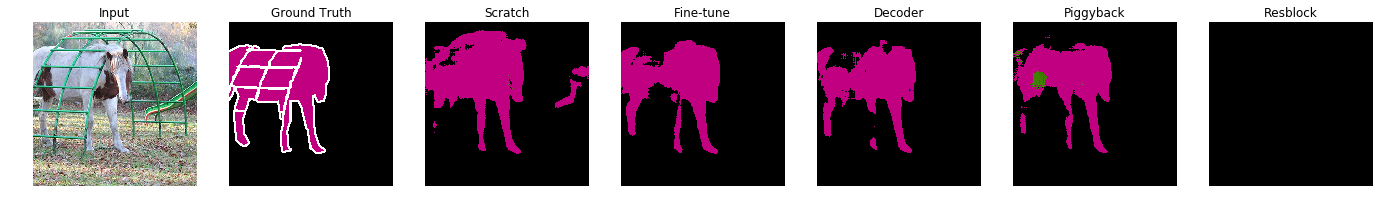

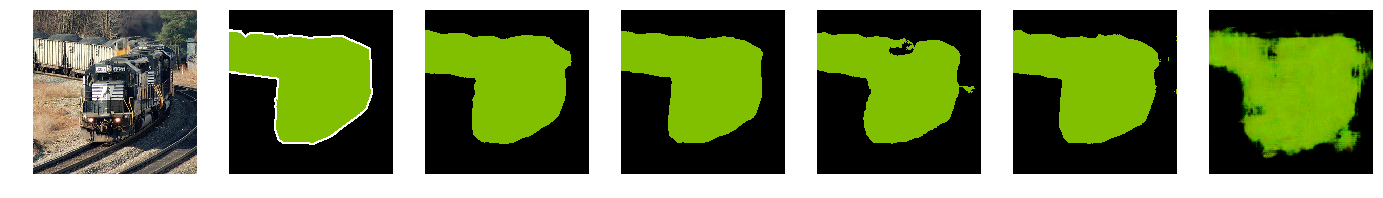

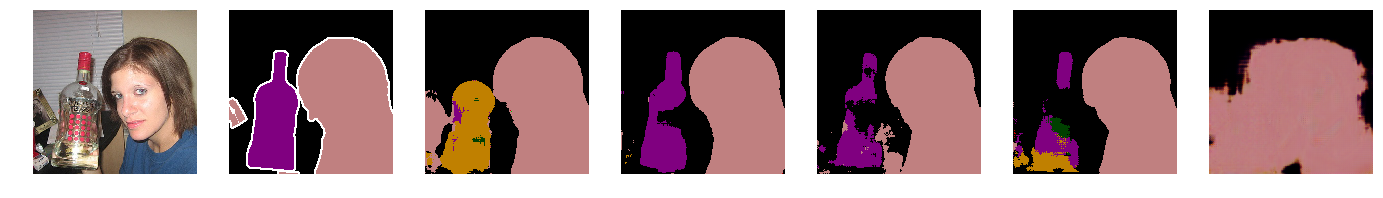

In [11]:
with torch.no_grad():
    for idx, (data, target) in enumerate(loader):
        img = data
        data, target = data.cuda(), target.cuda()
        
        output = Decoder(data)
        prediction_decoder = output.data.max(1)[1].squeeze_(1).squeeze_(0).cpu().numpy()
        prediction_decoder = colorize_mask(prediction_decoder)
        
        output = Full(data)
        prediction_full = output.data.max(1)[1].squeeze_(1).squeeze_(0).cpu().numpy()
        prediction_full = colorize_mask(prediction_full)
        
        output = Piggyback(data)
        prediction_piggyback = output.data.max(1)[1].squeeze_(1).squeeze_(0).cpu().numpy()
        prediction_piggyback = colorize_mask(prediction_piggyback)
        
        output = Scratch(data)
        prediction_scratch = output.data.max(1)[1].squeeze_(1).squeeze_(0).cpu().numpy()
        prediction_scratch = colorize_mask(prediction_scratch)
        
        data, target = loader_norm.dataset.__getitem__(idx)
        data, target = data.unsqueeze(0).cuda(), target.unsqueeze(0).cuda()
        output = Resblock(data)
        prediction_resblock = output.data
        prediction_resblock = prediction_resblock[0].cpu().numpy()
        prediction_resblock = (np.transpose(prediction_resblock, (1, 2, 0)) + 1) / 2.0 * 255.0
        prediction_resblock = prediction_resblock.astype(np.uint8)
        
        # 結果を表示
        img = Image.open(loader.dataset.images[idx]).convert('RGB')
        img = crop_center(img, crop_size, crop_size)
        target = Image.open(loader.dataset.masks[idx])
        target = crop_center(target, crop_size, crop_size)
        target = np.array(target, dtype=np.uint8)
        target = colorize_mask(target)
        
        plt.figure(figsize=(24, 16))
        
        plt.subplot(1,7,1),plt.imshow(img)
        plt.axis('off')
        if idx%3 == 0:
            plt.title("Input")
        
        plt.subplot(1,7,2),plt.imshow(target)
        plt.axis('off')
        if idx%3 == 0:
            plt.title("Ground Truth")
            
        plt.subplot(1,7,3),plt.imshow(prediction_scratch)
        plt.axis('off')
        if idx%3 == 0:
            plt.title("Scratch")
        
        plt.subplot(1,7,4),plt.imshow(prediction_full)
        plt.axis('off')
        if idx%3 == 0:
            plt.title("Fine-tune")
        
        plt.subplot(1,7,5),plt.imshow(prediction_decoder)
        plt.axis('off')
        if idx%3 == 0:
            plt.title("Decoder")
            
        plt.subplot(1,7,6),plt.imshow(prediction_piggyback)
        plt.axis('off')
        if idx%3 == 0:
            plt.title("Piggyback")
        
        plt.subplot(1,7,7),plt.imshow(prediction_resblock)
        plt.axis('off')
        if idx%3 == 0:
            plt.title("Resblock")
        
        if idx == 20:
            break
            
del Scratch
del Full
del Decoder
del Piggyback
del Resblock

## 2. 各 Resblock の比較 (L1, L2, GANLoss)

In [12]:
Resblock_L1 = modnets.resnet_generator(False)
model_path = 'best_models/resblock/auto_encoder_pascal_L1/best_resblock_auto_encoder_pascal_L1.pth'
checkpoint = torch.load(model_path)
state = OrderedDict()
for k, v in checkpoint['model_state'].items():
    name = k[7:]
    state[name] = v
Resblock_L1.load_state_dict(state)
Resblock_L1 = Resblock_L1.cuda()
Resblock_L1 = Resblock_L1.eval()

In [13]:
Resblock_L2 = modnets.resnet_generator(False)
model_path = 'best_models/resblock/auto_encoder_pascal/best_resblock_auto_encoder_pascal.pth'
checkpoint = torch.load(model_path)
state = OrderedDict()
for k, v in checkpoint['model_state'].items():
    name = k[7:]
    state[name] = v
Resblock_L2.load_state_dict(state)
Resblock_L2 = Resblock_L2.cuda()
Resblock_L2 = Resblock_L2.eval()

In [14]:
Resblock_adv = modnets.resnet_generator(False)
model_path = 'best_models/resblock/auto_encoder_pascal_adv/best_resblock_auto_encoder_pascal_adv.pth'
checkpoint = torch.load(model_path)
state = OrderedDict()
for k, v in checkpoint['model_state'].items():
    name = k[7:]
    state[name] = v
Resblock_adv.load_state_dict(state)
Resblock_adv = Resblock_adv.cuda()
Resblock_adv = Resblock_adv.eval()

## 出力結果

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4da0f56080>>
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/anaconda3

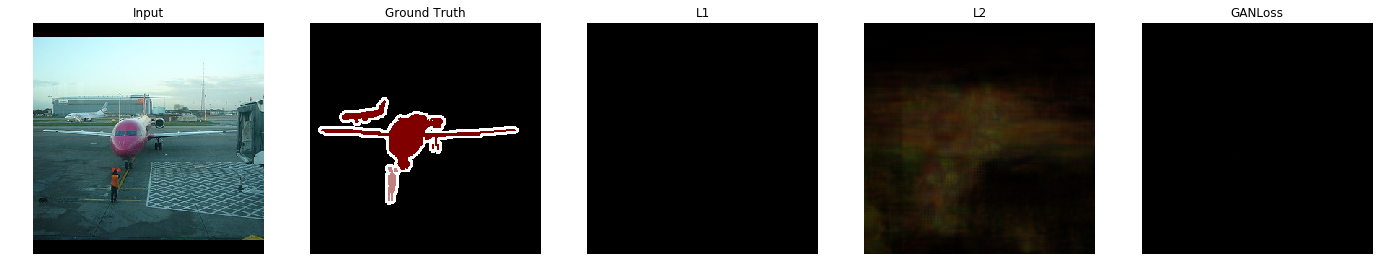

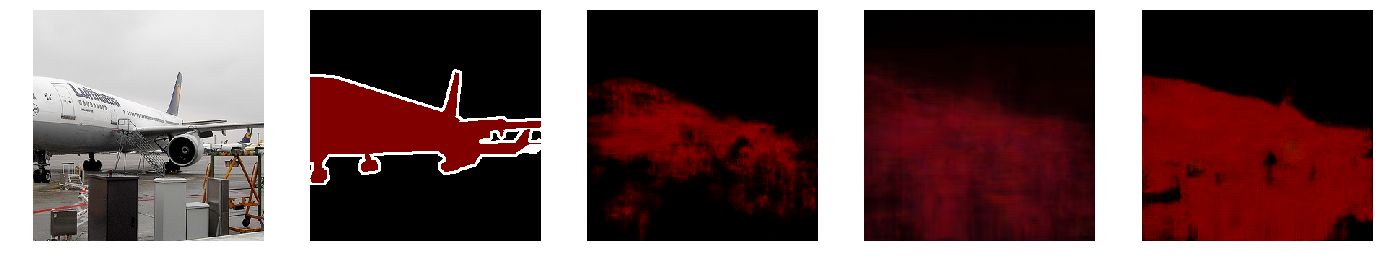

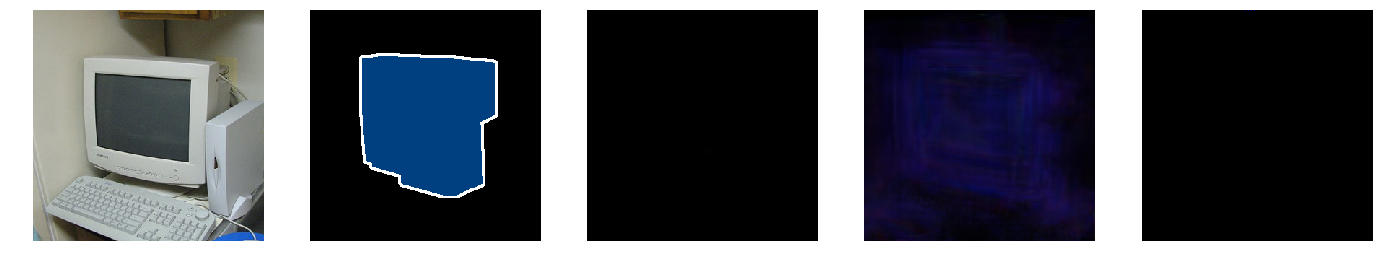

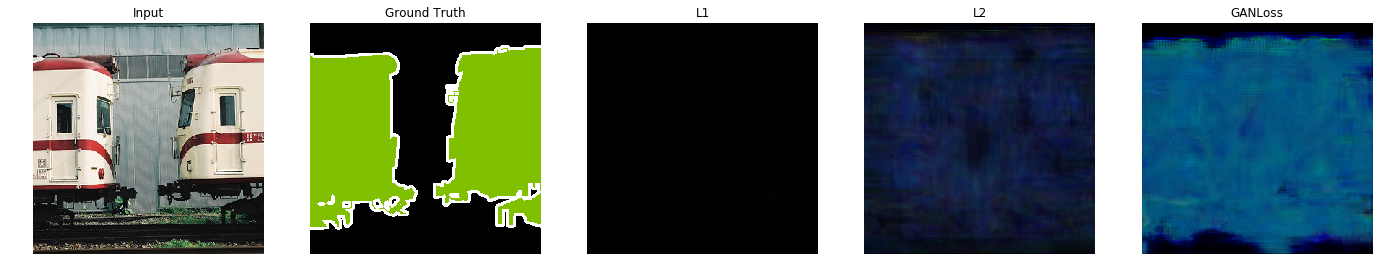

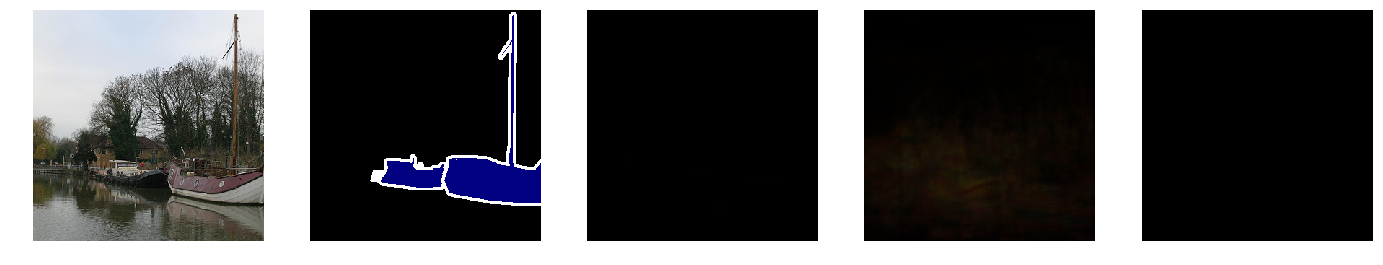

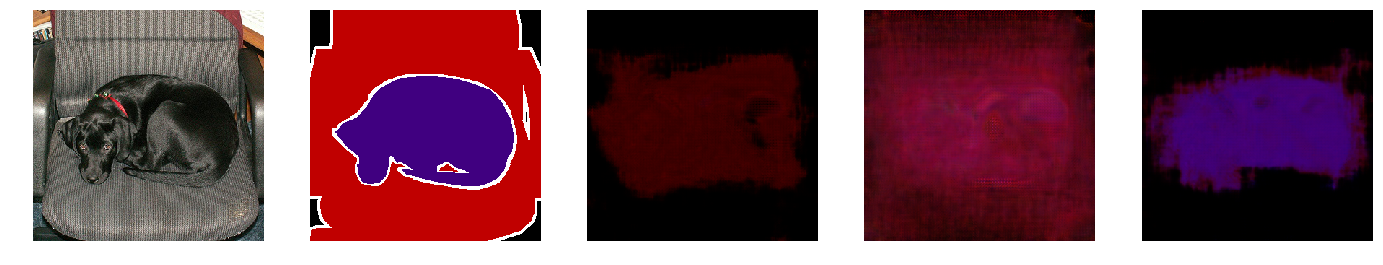

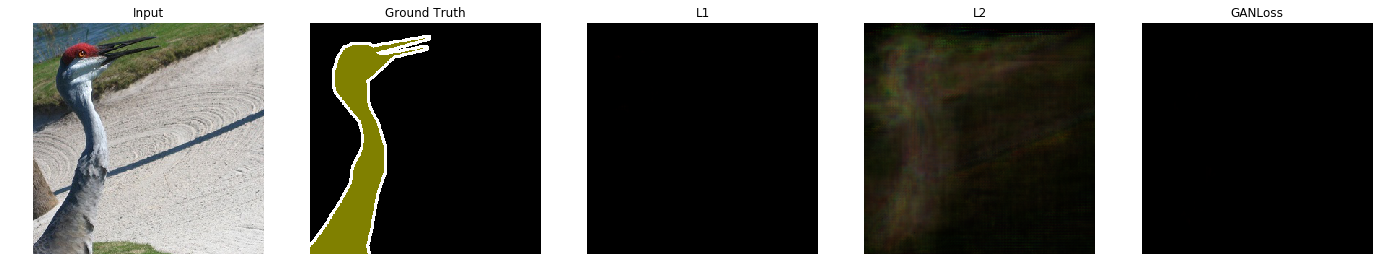

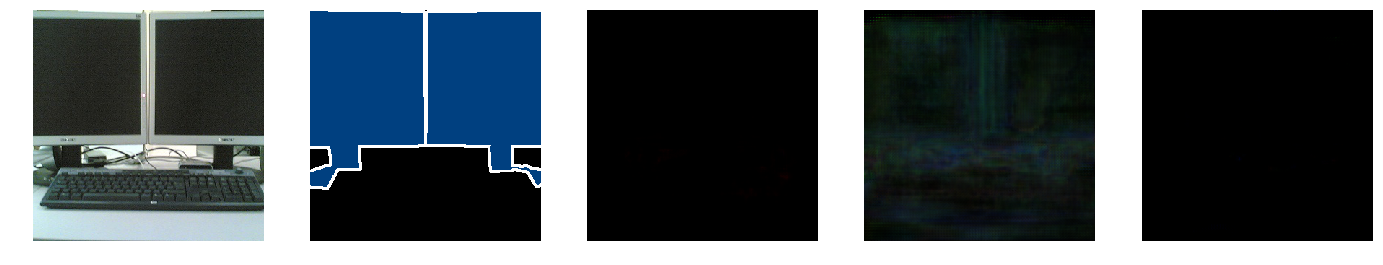

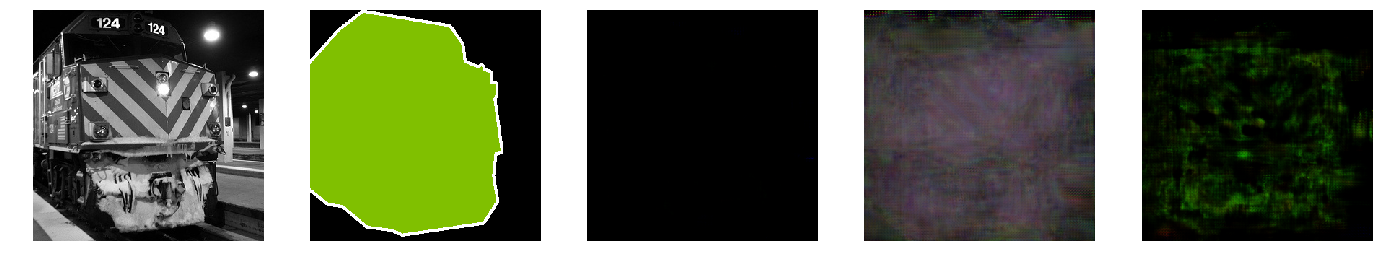

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


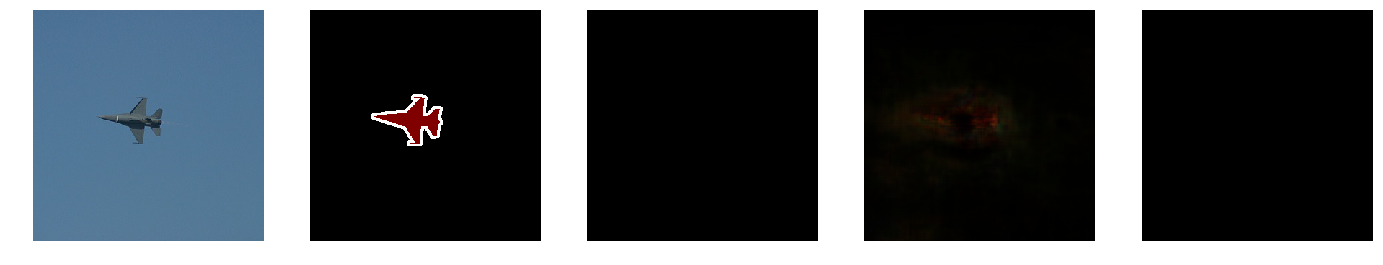

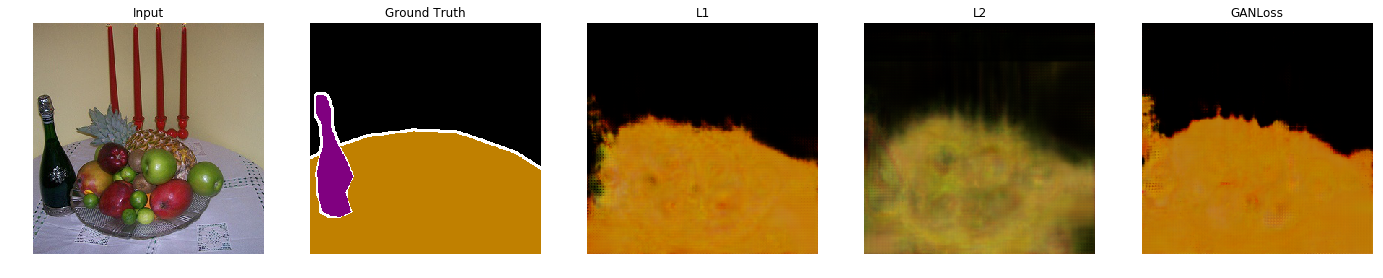

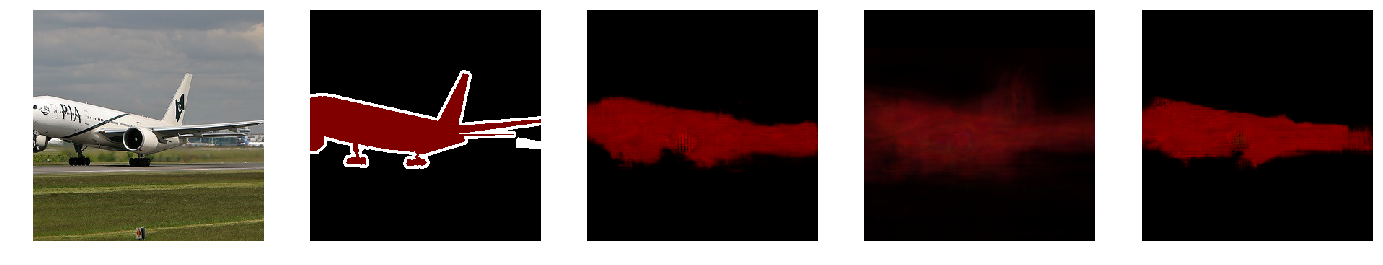

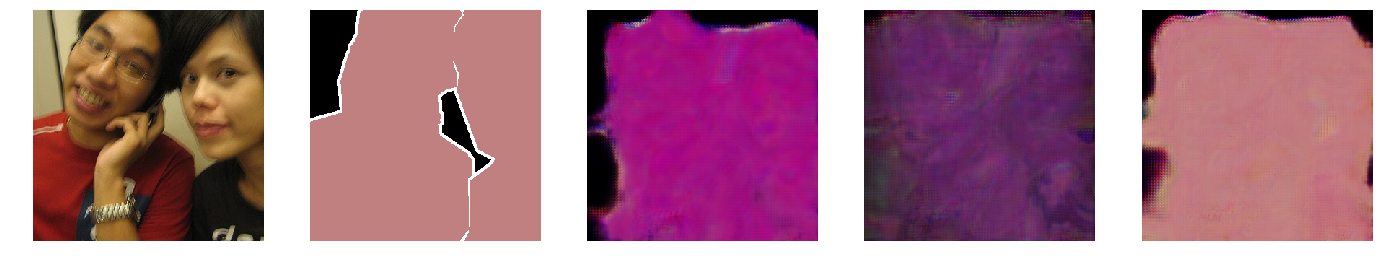

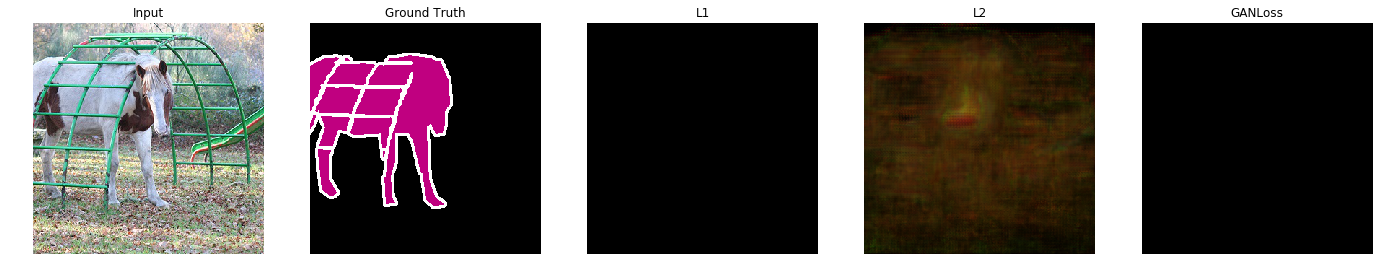

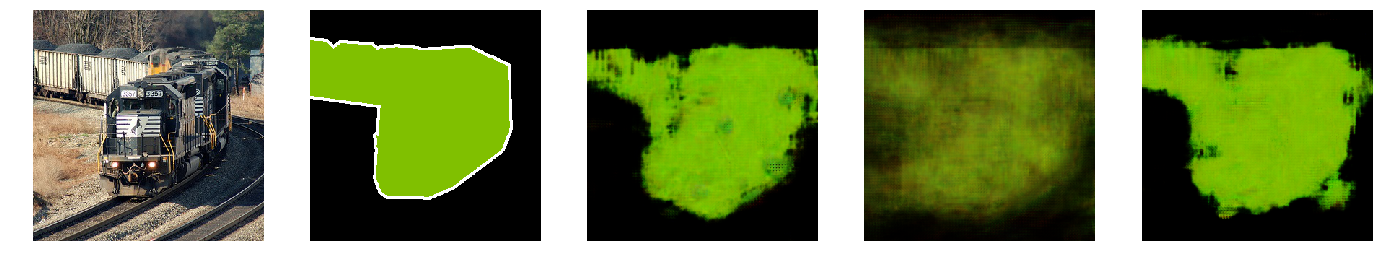

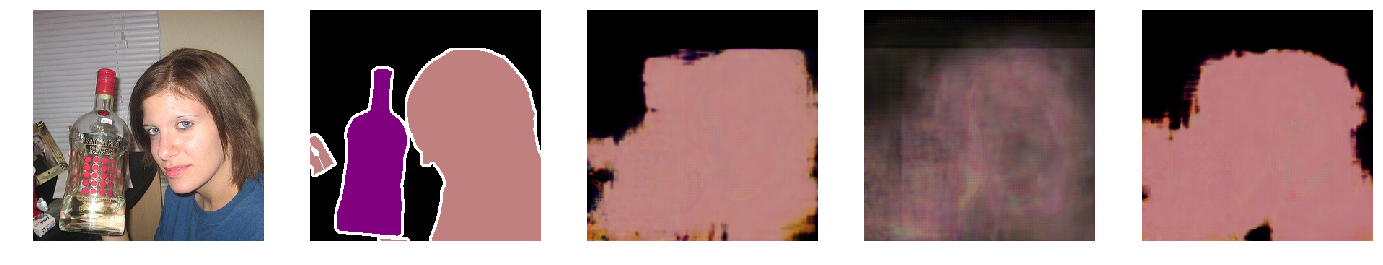

In [15]:
with torch.no_grad():
    for idx, (data, target) in enumerate(loader_norm):
        # inpuy, label
        img = Image.open(loader.dataset.images[idx]).convert('RGB')
        img = crop_center(img, crop_size, crop_size)
        label = Image.open(loader.dataset.masks[idx])
        label = crop_center(label, crop_size, crop_size)
        label = np.array(label, dtype=np.uint8)
        label = colorize_mask(label)
        
        plt.figure(figsize=(24, 16))
        
        plt.subplot(1,5,1),plt.imshow(img)
        plt.axis('off')
        if idx%3 == 0:
            plt.title("Input")
        
        plt.subplot(1,5,2),plt.imshow(label)
        plt.axis('off')
        if idx%3 == 0:
            plt.title("Ground Truth")
        
        # generato
        img = data
        data, target = data.cuda(), target.cuda()
        
        output = Resblock_L1(data)
        prediction_resblock = output.data
        prediction_resblock = prediction_resblock[0].cpu().numpy()
        prediction_resblock = (np.transpose(prediction_resblock, (1, 2, 0)) + 1) / 2.0 * 255.0
        prediction_resblock = prediction_resblock.astype(np.uint8) 
        plt.subplot(1,5,3),plt.imshow(prediction_resblock)
        plt.axis('off')
        if idx%3 == 0:
            plt.title("L1")
        
        output = Resblock_L2(data)
        prediction_resblock = output.data
        prediction_resblock = prediction_resblock[0].cpu().numpy()
        prediction_resblock = (np.transpose(prediction_resblock, (1, 2, 0)) + 1) / 2.0 * 255.0
        prediction_resblock = prediction_resblock.astype(np.uint8)
        plt.subplot(1,5,4),plt.imshow(prediction_resblock)
        plt.axis('off')
        if idx%3 == 0:
            plt.title("L2")
        
        output = Resblock_adv(data)
        prediction_resblock = output.data
        prediction_resblock = prediction_resblock[0].cpu().numpy()
        prediction_resblock = (np.transpose(prediction_resblock, (1, 2, 0)) + 1) / 2.0 * 255.0
        prediction_resblock = prediction_resblock.astype(np.uint8)
        plt.subplot(1,5,5),plt.imshow(prediction_resblock)
        plt.axis('off')
        if idx%3 == 0:
            plt.title("GANLoss")
            
        if idx == 20:
            break